# Annealing

In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_04_callbacks")' FastaiNotebook_04_callbacks

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_04_callbacks")
		FastaiNotebook_04_callbacks
With SwiftPM flags: []
Working in: /tmp/tmpzwm_jyhg
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.17s
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_04_callbacks' (6 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


## Load data

In [ ]:
import FastaiNotebook_04_callbacks
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow

In [ ]:
let data = mnistDataBunch(flat: true)

In [ ]:
let (n,m) = (60000,784)
let c = 10
let nHid = 50

In [ ]:
let opt = SGD<BasicModel, Float>(learningRate: 1e-2)

In [ ]:
func modelInit() -> BasicModel {return BasicModel(nIn: m, nHid: nHid, nOut: c)}

In [ ]:
// TODO: When TF-421 is fixed, switch back to the normal `softmaxCrossEntropy`.

@differentiable(vjp: _vjpSoftmaxCrossEntropy)
func softmaxCrossEntropy1<Scalar: TensorFlowFloatingPoint>(
    _ features: Tensor<Scalar>, _ labels: Tensor<Scalar>
) -> Tensor<Scalar> {
    return Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels).loss.mean()
}

@usableFromInline
func _vjpSoftmaxCrossEntropy<Scalar: TensorFlowFloatingPoint>(
    features: Tensor<Scalar>, labels: Tensor<Scalar>
) -> (Tensor<Scalar>, (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
    let (loss, grad) = Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels)
    let batchSize = Tensor<Scalar>(features.shapeTensor[0])
    return (loss.mean(), { v in ((v / batchSize) * grad, Tensor<Scalar>(0)) })
}

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)

In [ ]:
learner.delegates = [Learner.TrainEvalDelegate(), Learner.AvgMetric(metrics: [accuracy])]

In [ ]:
learner.fit(2)

Epoch 0: [0.47678834, 0.8797]
Epoch 1: [0.3552406, 0.9029]


## Recoder

The Recorder to save track of the loss and our scheduled learning rate. 

In [ ]:
// export
import Python
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [ ]:
// export
public func plot<S1, S2>(_ arr1: [S1], _ arr2: [S2], logScale:Bool = false, xLabel: String="", yLabel: String = "") 
    where S1:PythonConvertible, S2:PythonConvertible{
    plt.figure(figsize: [6,4])
    let (npArr1, npArr2) = (np.array(arr1), np.array(arr2))
    if logScale {plt.xscale("log")} 
    if !xLabel.isEmpty {plt.xlabel(xLabel)}
    if !yLabel.isEmpty {plt.ylabel(yLabel)}    
    let fig = plt.plot(npArr1, npArr2)
    plt.show(fig)
}

In [ ]:
// export
extension Learner where O.Scalar: PythonConvertible{
    public func makeRecorder() -> Recorder {
        return Recorder()
    }

    public class Recorder: Delegate {
        public var losses: [Loss] = []
        public var lrs: [O.Scalar] = []
        
        public override func batchDidFinish(learner: Learner) {
            if learner.inTrain {
                losses.append(learner.currentLoss)
                lrs.append(learner.optimizer.learningRate)
            }
        }
        
        public func plotLosses(){
            plot(Array(0..<losses.count), losses.map{$0.scalar}, xLabel:"iteration", yLabel:"loss")
        }
        
        public func plotLRs(){
            plot(Array(0..<lrs.count), lrs, xLabel:"iteration", yLabel:"lr")
        }
        
        public func plotLRFinder(){
            plot(lrs, losses.map{$0.scalar}, logScale: true, xLabel:"lr", yLabel:"loss")
        }
        
    }
}

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)

In [ ]:
let recorder = learner.makeRecorder()

In [ ]:
learner.delegates = [Learner.TrainEvalDelegate(), Learner.AvgMetric(metrics: [accuracy]), recorder]

In [ ]:
learner.fit(2)

Epoch 0: [0.4803127, 0.8782]
Epoch 1: [0.3612086, 0.9027]


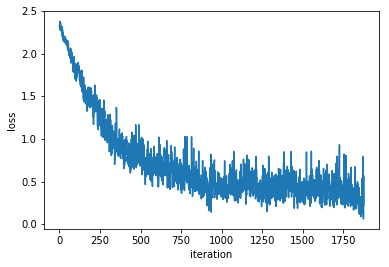

In [ ]:
recorder.plotLosses()

### Progress bar

It's nice to keep track of where we're at in the training with a progress bar.

In [ ]:
// export
import Glibc
import Foundation

In [ ]:
// export
func formatTime(_ t: Float) -> String {
    let t = Int(t)
    let (h,m,s) = (t/3600, (t/60)%60, t%60)
    return h != 0 ? String(format: "%02d:%02d:%02d", h, m, s) : String(format: "%02d:%02d", m, s)
}

In [ ]:
formatTime(78.23)

"01:18"


In [ ]:
// export
public struct ProgressBar{
    let total: Int
    let length: Int = 50
    let showEvery: Float = 0.02
    let fillChar: Character = "X"
    public var comment: String = ""
    private var lastVal: Int = 0
    private var waitFor: Int = 0
    private var startTime: UInt64 = 0
    private var lastShow: UInt64 = 0
    private var estimatedTotal: Float = 0.0
    private var bar: String = ""
    
    public init(_ c: Int) { total = c }
    
    public mutating func update(_ val: Int){
        if val == 0 {
            startTime = DispatchTime.now().uptimeNanoseconds
            lastShow = startTime
            waitFor = 1
            update_bar(0)
        } else if val >= lastVal + waitFor || val == total {
            lastShow = DispatchTime.now().uptimeNanoseconds
            let averageTime = Float(lastShow - startTime) / (1e9 * Float(val))
            waitFor = max(Int(averageTime / (showEvery + 1e-8)), 1)
            estimatedTotal = Float(total) * averageTime
            update_bar(val)
        }
    }
    
    public mutating func update_bar(_ val: Int){
        lastVal = val
        bar = String(repeating: fillChar, count: (val * length) / total)
        bar += String(repeating: "-", count: length - (val * length) / total)
        let pct = String(format: "%.2f", 100.0 * Float(val)/Float(total))
        let elapsedTime = Float(lastShow - startTime) / 1e9
        let remaingTime = estimatedTotal - elapsedTime
        bar += " \(pct)% [\(val)/\(total) \(formatTime(elapsedTime))<\(formatTime(remaingTime))"
        bar += comment.isEmpty ? "]" : " \(comment)]"
        print(bar, terminator:"\r")
        fflush(stdout)
    }
    
    public func remove(){
        print(String(repeating: " ", count: bar.count), terminator:"\r")
        fflush(stdout)
    }
}

In [ ]:
var tst = ProgressBar(100)
for i in 0...100{
    tst.update(i)
    usleep(50000)
}
tst.remove()

In [ ]:
// export
extension Learner {
    public class ShowProgress: Delegate {
        var pbar: ProgressBar? = nil
        var iter: Int = 0
        
        public override func epochWillStart(learner: Learner) {
            pbar = ProgressBar(learner.data.train.count(where: {_ in true}))
            iter = 0
            pbar!.update(iter)
        }
        
        public override func validationWillStart(learner: Learner) {
            if pbar != nil { pbar!.remove() }
            pbar = ProgressBar(learner.data.valid.count(where: {_ in true}))
            iter = 0
            pbar!.update(iter)
        }
        
        public override func epochDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
        
        public override func batchDidFinish(learner: Learner) {
            iter += 1
            pbar!.update(iter)
        }
        
        public override func trainingDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
    }
}

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)

In [ ]:
let recorder = learner.makeRecorder()
learner.delegates = [Learner.TrainEvalDelegate(), Learner.ShowProgress(), 
                     Learner.AvgMetric(metrics: [accuracy]), recorder]

In [ ]:
learner.fit(2)

Epoch 0: [0.46732858, 0.877]                                                    
Epoch 1: [0.35487035, 0.9013]                                                   


### Annealing

In [ ]:
/// Simple SGD optimizer with a modifiable learning rate.
/// Remove me when we have a new linux build that includes the TF-425 fix.
protocol SettableOptimizer: Optimizer {
    var learningRate: Scalar { get set }
}

public class SettableSGD<Model: Layer>: SettableOptimizer
    where Model.AllDifferentiableVariables == Model.CotangentVector {
    /// The learning rate.
    public var learningRate: Float {
        willSet(newLearningRate) {
            precondition(newLearningRate >= 0, "Learning rate must be non-negative")
        }
    }

    public init(learningRate: Float = 0.01) {
        precondition(learningRate >= 0, "Learning rate must be non-negative")
        self.learningRate = learningRate
    }

    public func update(_ model: inout Model.AllDifferentiableVariables,
                       along direction: Model.CotangentVector) {
        for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Scalar>.self) {
            model[keyPath: kp] -= learningRate * direction[keyPath: kp]
        }
    }
}


In [ ]:
let opt = SettableSGD<BasicModel>(learningRate: 1e-2)

In [ ]:
/// A non-generalized learning rate scheduler
extension Learner where O: SettableOptimizer, O.Scalar == Float {

    public class ParamScheduler: Delegate {
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        public var scheduler: ScheduleFunc
        
        public init(scheduler: @escaping (Float) -> Float) {
            self.scheduler = scheduler
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.optimizer.learningRate = scheduler(learner.pctEpochs/Float(learner.epochCount))
        }
    }
}


In [ ]:
// export
func linearSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start + pct * (end - start)
}

func makeAnnealer(start: Float, end: Float, schedule: @escaping (Float, Float, Float) -> Float) -> (Float) -> Float { 
    return { pct in return schedule(start, end, pct) }
}

In [ ]:
let annealer = makeAnnealer(start: 1e-2, end: 0.1, schedule: linearSchedule)
annealer(0.3)

0.037


In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeRecorder()

In [ ]:
learner.delegates = [Learner.TrainEvalDelegate(), Learner.ShowProgress(), 
                     Learner.AvgMetric(metrics: [accuracy]), recorder,
                     type(of: learner).ParamScheduler(scheduler: annealer)]

Bug: compiler crashes if we use `Learner.ParamScheduler(scheduler: annealer)` up here.

In [ ]:
learner.fit(2)

Epoch 0: [0.30897856, 0.915]                                                    
Epoch 1: [0.21274687, 0.9387]                                                   


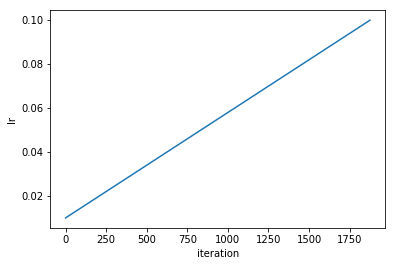

In [ ]:
recorder.plotLRs()

More annealing functions

In [ ]:
// export
func constantSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start
}

func cosineSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start + (1 + cos(Float.pi*(1-pct))) * (end-start) / 2
}

func expSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start * pow(end / start, pct)
}

In [ ]:
// export
func combineSchedules(pcts: [Float], schedules: [(Float) -> Float]) -> ((Float) -> Float){
    var cumPcts: [Float] = [0]
    for pct in pcts {cumPcts.append(cumPcts.last! + pct)}
    func inner(pct: Float) -> Float{
        if (pct == 0.0) { return schedules[0](0.0) }
        let i = cumPcts.firstIndex(where: {$0 >= pct})! - 1
        let actualPos = (pct-cumPcts[i]) / (cumPcts[i+1]-cumPcts[i])
        return schedules[i](actualPos)
    }
    return inner
}

In [ ]:
let mySchedule = combineSchedules(pcts: [0.3, 0.7], 
                                  schedules: [makeAnnealer(start: 0.3, end: 0.6, schedule: cosineSchedule),
                                              makeAnnealer(start: 0.6, end: 0.2, schedule: cosineSchedule)])

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeRecorder()

In [ ]:
learner.delegates = [Learner.TrainEvalDelegate(), Learner.ShowProgress(), 
                     Learner.AvgMetric(metrics: [accuracy]), recorder,
                     type(of: learner).ParamScheduler(scheduler: mySchedule)]

In [ ]:
learner.fit(2)

Epoch 0: [0.14421752, 0.9543]                                                   
Epoch 1: [0.08293003, 0.9747]                                                   


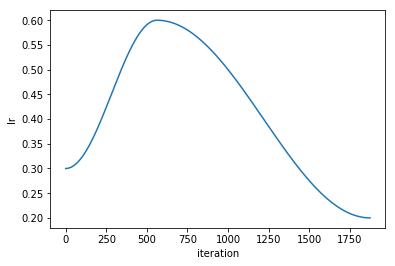

In [ ]:
recorder.plotLRs()

### LR Finder

In [ ]:
/// LR Finder test
extension Learner where O: SettableOptimizer, O.Scalar == Float {

    public class LRFinder2: Delegate {
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        private var scheduler: ScheduleFunc
        private var numIter: Int
        private var minLoss: Float? = nil
        
        public init(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) {
            scheduler = makeAnnealer(start: start, end: end, schedule: expSchedule)
            self.numIter = numIter
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.optimizer.learningRate = scheduler(Float(learner.currentIter)/Float(numIter))
        }
        
        override public func batchDidFinish(learner: Learner) throws {
            if minLoss == nil {minLoss = learner.currentLoss.scalar}
            else { 
                if learner.currentLoss.scalar! < minLoss! { minLoss = learner.currentLoss.scalar!}
                if learner.currentLoss.scalar! > 4 * minLoss! { throw LearnerAction.stop }
                if learner.currentIter >= numIter { throw LearnerAction.stop }
            }
        }
    }
}

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeRecorder()

In [ ]:
learner.delegates = [Learner.TrainEvalDelegate(), type(of: learner).LRFinder2(), Learner.ShowProgress(), recorder]

In [ ]:
learner.fit(2)

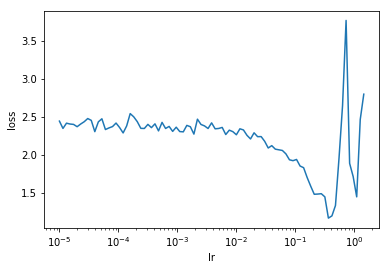

In [ ]:
recorder.plotLRFinder()